# Notebook 3: Movement Primitive Interneurons

### General Overview

The movement primitive layer contains 672 movement primitive (MP) interneurons (INs) that act as coincidence detectors, firing whenever two or three inputs overlap. Each input is a velocity or position spike train from a different joint (α, β, γ) within a leg. All possible combinations result in 112 unique MP INs per leg, totaling 672 across all legs. The aim of this layer is to signal leg-specific parameters, such as the swing phase, stance phase, or transitions between these phases.

### Cell-by-Cell Description

#### Importing Modules and Creating Folders

This cell serves to import general functions, modules, and dictionaries from the 'general' module. Additionally, it imports the LIF class, which is integral to subsequent analyses. The LIF class is a simplified LIF neuron, see 'classes.py' for more information.


In [2]:
from general import *
from classes import LIF

create_folder_if_not_exists('images')
create_folder_if_not_exists('images/motion_primitive_neuron')

Folder 'images' already exists.
Folder 'images/motion_primitive_neuron' already exists.


#### Defining Functions

This cell defines several useful functions.

*get_encoding()*

Generates synapse connection permutations, synapse types, weights, and masks for given position and velocity weights.

*prepare_spikes_primitive()*

This function intertwines velocity and position spike trains, applies the permutations generated in get_encoding() and applies a positive mask.

*get_stance_swing_bins()*

This function extracts likelihood of spiking in each swing and stance bin from the spiking activity of a neuron. This can be extracted from annotated gait data and spike trains. 

In [3]:
# Generates encoding permutations, synapse types, weights, and masks for given position and velocity weights.
def get_encoding(w_pos=[0, 0, 0, 0, 0, 0, 0], w_vel=[0, 0, 0, 0, 0, 0, 0], n=6, n_simulations=1):
    
    # Define the possible synapse connections from 1st order interneurons, and assign them an integer
    connections_str = ['none', 'Vel-', 'Vel+', 'Pos-', 'Pos+']
    connections_int = [-np.inf, 0, 1, 2, 3]

    # Generate all possible permutations of 3 synapse connections
    connections_permutated_str = np.array(list(product(connections_str, repeat=3)))
    connections_permutated_int = np.array(list(product(connections_int, repeat=3)))

    synapse_type = []

    # Determine synapse type for each permutation, e.g., synapse type 0 is E_0 or p-p. 
    for permutation in connections_permutated_str:
        if 'none' in permutation:
            # Check if 2 position synapse connections are present with 1 'none', E_1, p-p is synapse type 0
            if (permutation == 'Pos+').sum() + (permutation == 'Pos-').sum() == 2:
                synapse_type.append(0)
            # Check if 2 velocity synapse connections are present with 1 'none', E_2, v-v is synapse type 1
            elif (permutation == 'Vel+').sum() + (permutation == 'Vel-').sum() == 2:
                synapse_type.append(1)
            # Check if 1 position and 1 velocity synapse connections are present with 1 'none', E_3, p-v is synapse type 2
            elif (permutation == 'Pos+').sum() + (permutation == 'Pos-').sum() == 1 and (permutation == 'Vel+').sum() + (permutation == 'Vel-').sum() == 1:
                synapse_type.append(2)
            else:
            # These are the combinations with more than one 'none', to be discarded later
                synapse_type.append(-1)
        else:
            # Check if 2 position and 1 velocity synapse connections are present, E_4, p-p-v is synapse type 3
            if (permutation == 'Pos+').sum() + (permutation == 'Pos-').sum() == 2:
                synapse_type.append(3)
            # Check if 2 velocity and 1 position synapse connections are present, E_5, v-v-p is synapse type 4
            elif (permutation == 'Vel+').sum() + (permutation == 'Vel-').sum() == 2:
                synapse_type.append(4)
            # Check if 3 position synapse connections are present, E_6, p-p-p is synapse type 5
            elif (permutation == 'Pos+').sum() + (permutation == 'Pos-').sum() == 3:
                synapse_type.append(5)
            # Otherwise it has 3 velocity synapse connections, E_7, v-v-v is synapse type 6
            else:
                synapse_type.append(6)

    # Filter out invalid synapse types (-1), with more than 1 'none'
    zero_index = np.where(np.array(synapse_type) == -1)[0]
    synapse_type = list(np.delete(synapse_type, zero_index))
    connections_permutated_str = np.delete(connections_permutated_str, zero_index, axis=0)
    connections_permutated_int = np.delete(connections_permutated_int, zero_index, axis=0)

    # Initialize weights array, can be the same structure as "connections_permutated_str", because each synapse needs a weight
    weights = np.zeros_like(connections_permutated_str, dtype=float)

    # Assign weights based on encoding types, E_1 through E_7 and pos and vel connections carry different weights defined when calling this function
    for i, j in np.ndindex(weights.shape):
        if 'Pos' in connections_permutated_str[i, j]:
            weights[i, j] = w_pos[synapse_type[i]]
        elif 'Vel' in connections_permutated_str[i, j]:
            weights[i, j] = w_vel[synapse_type[i]]

    # Create masks for 'none' and non-'none' encodings. negative_mask -> none = 1, non-none = 0, positive mask -> none = 0, non-none = 1
    negative_mask = np.zeros_like(connections_permutated_str, dtype=float)
    negative_mask[connections_permutated_str == 'none'] = 1
    negative_mask = np.tile(negative_mask, (6, 1))
    negative_mask = negative_mask[:, :, np.newaxis].repeat(n_simulations, axis=2)
    positive_mask = 1 - negative_mask

    # Repeat weights and synapse types for 6 legs
    weights = np.tile(weights, (6, 1))
    weights = weights[:, :, np.newaxis].repeat(n_simulations, axis=2)
    synapse_type = synapse_type * 6

    # Add extra legs to connections_permutated_int (+12 per leg)
    extra = np.array([0, 4, 8])
    extra = np.tile(extra, (connections_permutated_int.shape[0], 1))
    connections_permutated_int_legs = (connections_permutated_int + extra).clip(min=0)
    extra_2 = np.linspace(0, 12 * (n - 1), num=n).repeat(3 * connections_permutated_int_legs.shape[0])
    connections_permutated_int_legs = (np.tile(connections_permutated_int_legs.flatten(), n) + extra_2).astype(int)

    # Increment connections_permutated_int such that none = 0 and vel- = 1 etc.
    connections_permutated_int = connections_permutated_int + 1
    connections_permutated_int[connections_permutated_int == -np.inf] = 0

    return connections_permutated_str, connections_permutated_int.astype(int), connections_permutated_int_legs, synapse_type, weights, positive_mask, negative_mask

# This function intertwines velocity and position spike trains, applies the permutations generated in get_encoding() and applies a positive mask
def prepare_spikes_primitive(spike_velocity, spike_position, permutations, mask, n_simulations=1):    
    # Initialize an empty tuple to hold combined velocity and position spikes
    toepel = ()
    
    # Loop through the range to combine velocity and position spikes in pairs
    # [vel-, vel+, pos-, pos+, vel-, vel+, etc.]
    # [0, 1, 2, 3, 4, 5, 6, etc.] would be the permutation code
    for i in range(18):
        toepel += (spike_velocity[[0 + 2 * i, 1 + 2 * i]], spike_position[[0 + 2 * i, 1 + 2 * i]])

    # Concatenate all the pairs to form a single array
    pos_vel_spikes = np.concatenate(toepel)
    
    # Apply permutations and reshape to match the mask shape, then apply the mask
    pos_vel_spikes = pos_vel_spikes[permutations].reshape(mask.shape) * mask

    return pos_vel_spikes


def get_stance_swing_bins(gait, spike_train, n_bins):
    
    # Identify the indices (timestep) where the gait phase changes, either swing to stance or stance to swing
    change_index = np.where(gait[:-1] != gait[1:])[0]
    
    # Calculate the number of complete swing_stance phases
    n_phases = (change_index.size // 2) - 1

    # Initialize arrays to hold spike rates and likelihoods of spiking for each bin and phase
    swing_bin_rate = np.zeros((n_phases, n_bins))
    stance_bin_rate = np.zeros((n_phases, n_bins))
    swing_bin_likelihood = np.zeros((n_phases, n_bins))
    stance_bin_likelihood = np.zeros((n_phases, n_bins))

    # Loop through each phase to calculate spike rates and likelihoods
    for i in range(n_phases):
        # Calculate the index that this phases' swing starts, ends and stance ends. end_swing = start_stance
        start_idx_swing = change_index[2 * i + (1 if gait[0] == 0 else 0)]
        end_idx_swing = change_index[1 + 2 * i + (1 if gait[0] == 0 else 0)]
        end_idx_stance = change_index[2 + 2 * i + (1 if gait[0] == 0 else 0)]

        # extract the swing and stance phase spike trains, and split them in n_bins
        spikes_swing = np.array_split(spike_train[start_idx_swing:end_idx_swing], n_bins)
        spikes_stance = np.array_split(spike_train[end_idx_swing:end_idx_stance], n_bins)

        # Calculate the total spike count for each bin
        for j in range(n_bins):
            swing_bin_rate[i, j] = np.sum(spikes_swing[j])
            stance_bin_rate[i, j] = np.sum(spikes_stance[j])

        # Calculate the likelihood of spiking in each bin
        stance_bin_likelihood[i, stance_bin_rate[i, :] > 0.5] = 1
        swing_bin_likelihood[i, swing_bin_rate[i, :] > 0.5] = 1

    # Compute the average spike rates and likelihoods across all phases
    swing_bin_rate = np.mean(swing_bin_rate, axis=0)
    stance_bin_rate = np.mean(stance_bin_rate, axis=0)
    swing_bin_likelihood = np.mean(swing_bin_likelihood, axis=0)
    stance_bin_likelihood = np.mean(stance_bin_likelihood, axis=0)

    return swing_bin_rate, stance_bin_rate, swing_bin_likelihood, stance_bin_likelihood

#### Movement Primitive Ground Truth

Based on the real joint angles, it is possible to determine when a certain joint is moving forward (vel+), moving backward (vel-), is in the positive domain with respect to rest (pos+), or is in the negative domain with respect to rest (pos-). Reference spike trains for these first-order interneurons can be created. By applying the same preprocessing as used for the movement primitive neurons, a ground truth reference for the movement primitive neurons can be established. Performance can then be assessed against this ground truth by constructing a confusion matrix. First, the joint angles are loaded. 

In [4]:
# Load joint angles, position spike data and velocity spike data from files
with open('temp_data/joint_angles.npy', 'rb') as file:
    joint_angles = np.load(file)
    
with open('temp_data/spike_position', 'rb') as file:
    spike_position = np.load(file) 
    
with open('temp_data/spike_velocity', 'rb') as file:
    spike_velocity = np.load(file) 

The permutations are extracted from *get_encoding()*, and arrays are initialized.

In [5]:
# Constants
N_BINS = 100

# Retrieve permutation parameters, synapse types, weights and masks. 
perm, perm2, permutations_final, synapse_type, weights_primitive, mask_positive, mask_negative = get_encoding([0]*7, [0]*7, n_simulations=parameters['N_SIMULATIONS'])

# Initialize ground truth arrays
ground_truth = np.empty((constants['N_STEPS'], len(synapse_type), parameters['N_SIMULATIONS']))
ground_truth_bins = np.zeros((N_BINS, len(synapse_type), parameters['N_SIMULATIONS']))
ground_vel, ground_pos = np.zeros((constants['N_STEPS'], 36, parameters['N_SIMULATIONS'])), np.zeros((constants['N_STEPS'], 36, parameters['N_SIMULATIONS']))

# Initialize confusion matrix components
true_positive, false_positive, true_negative, false_negative = [
    np.zeros((len(synapse_type), parameters['N_SIMULATIONS'])) for _ in range(4)
]

# Initialize group-level confusion matrix components
true_positive_groups, false_positive_groups, true_negative_groups, false_negative_groups = [
    np.zeros(7) for _ in range(4)
]

In [6]:
# Loop through each joint angle to calculate velocity and position reference spike trains
for i in tqdm(range(constants['N_ANGLES'])):
    
    # Calculate the resting angle value of the joint angle range for current joint
    resting_angle = np.max(joint_angles[:, i, :parameters['N_SIMULATIONS']], axis=(0, 1)) / 2 + \
                    np.min(joint_angles[:, i, :parameters['N_SIMULATIONS']], axis=(0, 1)) / 2
    
    # Calculate the velocity by differentiating joint angles and dividing by time step
    diff = np.diff(joint_angles[:, i, :parameters['N_SIMULATIONS']], axis=0) / constants['dt']
    
    # Identify indices (timestep and simulation) where joint velocity is negative (moving backward) and positive (moving forward)
    vel_dt_min, vel_sim_min = np.where(diff < 0)[0], np.where(diff < 0)[1]
    vel_dt_plus, vel_sim_plus = np.where(diff > 0)[0], np.where(diff > 0)[1]
    
    # Identify indices where joint angle is in the negative domain and positive domain relative to the resting angle
    pos_dt_min, pos_sim_min = np.where(joint_angles[:, i, :parameters['N_SIMULATIONS']] < resting_angle)[0], np.where(joint_angles[:, i, :parameters['N_SIMULATIONS']] < resting_angle)[1]
    pos_dt_plus, pos_sim_plus = np.where(joint_angles[:, i, :parameters['N_SIMULATIONS']] > resting_angle)[0], np.where(joint_angles[:, i, :parameters['N_SIMULATIONS']] > resting_angle)[1]
    
    # Assign spikes to the ground velocity and position arrays based on identified indices
    ground_vel[vel_dt_min, 0 + 2 * i, vel_sim_min] = 1
    ground_vel[vel_dt_plus, 1 + 2 * i, vel_sim_plus] = 1
    ground_pos[pos_dt_min, 0 + 2 * i, pos_sim_min] = 1
    ground_pos[pos_dt_plus, 1 + 2 * i, pos_sim_plus] = 1

# Loop through each step to prepare and process spikes just like the movement primitive layer, creating ground truth reference
for j in tqdm(range(constants['N_STEPS'])):
    # Prepare spikes for current step using velocity and position reference spikes, add a negative mask such that a none connection adds is a spike
    ground_truth_j = prepare_spikes_primitive(ground_vel[j, :, :parameters['N_SIMULATIONS']], 
                                              ground_pos[j, :, :parameters['N_SIMULATIONS']], 
                                              permutations_final, 
                                              mask_positive, 
                                              n_simulations=parameters['N_SIMULATIONS']) + mask_negative
    # Sum across the first axis (all three inputs)
    ground_truth_j = np.sum(ground_truth_j, axis=1)
    
    # If all three inputs were a spike, i.e. 1. The ground truth movement primitive output should be 1, otherwise 0.
    ground_truth[j, ground_truth_j > 2.9] = 1
    ground_truth[j, ground_truth_j < 2.9] = 0

# Convert ground truth data to bins for each simulation, the bins are used to compare with the movement primitive spikes
for k in range(parameters['N_SIMULATIONS']):
    ground_truth_bins[:, :, k] = convert_to_bins(ground_truth[:, :, k], N_BINS)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

#### Optimizing the Movement Primitive Layer

With the ground truth determined, the movement primitive layer can be optimized. The time constant $\tau$ and the weights $\omega_\text{vel}$ and $\omega_\text{pos}$ are varied in a grid search method. For each iteration, the matthews correlation coefficient (MCC) is calculated.  

In [7]:
if parameters['run_optimization']:
    # Define number of weights and tau values for the grid search optimization
    N_WEIGHTS = 9
    N_TAU = 7
    
    # Generate lists of tau and weight values for position and velocity
    tau_list = np.linspace(0e-3, 0.6e-3, num=N_TAU)
    w_pos_list = np.linspace(2e-3, 18e-3, num=N_WEIGHTS)
    w_vel_list = np.linspace(2e-3, 18e-3, num=N_WEIGHTS)
    
    # Initialize arrays for storing movement primitive spikes and MCC values
    spike_primitive = np.empty((constants['N_STEPS'], len(synapse_type), parameters['N_SIMULATIONS']), dtype=np.uint8)
    mcc_list = np.zeros((7, N_TAU, N_WEIGHTS, N_WEIGHTS))
    
    # Iterate over all combinations of tau and weight values
    for p, l, m in tqdm(np.ndindex(N_TAU, N_WEIGHTS, N_WEIGHTS), desc=f'Total iterations: {N_TAU * N_WEIGHTS * N_WEIGHTS}'):
        
        # Set weights for position and velocity
        w_pos = [w_pos_list[l], 0, w_pos_list[l], w_pos_list[l], w_pos_list[l], w_pos_list[l], 0]
        w_vel = [0, w_vel_list[m], w_vel_list[m], w_vel_list[m], w_vel_list[m], 0, w_vel_list[m]]
        
        # Get encoding parameters with current weights
        _, _, permutations_final, synapse_type, weights_primitive, mask_positive, mask_negative = get_encoding(w_pos, w_vel, n_simulations=parameters['N_SIMULATIONS'])
        
        # Define parameters for the LIF neuron model, setting tau and the weights
        primitive_parameters = {
            'tau': tau_list[p],                     # time constant tau
            'V_T': -50e-3, 
            'V_R': -70e-3, 
            'n': len(synapse_type),                 # The number of movement primitive neurons
            'w': weights_primitive,                 # The weights (3, 672), 672 is number of movement primitive neurons
            'N_input': 3,                           # 3 synapse connections per movement primitive neuron
            'dt': constants['dt'], 
            'n_sims': parameters['N_SIMULATIONS'],  # This simulation can run parallel for each trial
            'multiple_synapses': True               # Multiple input synapses (3)
        }
        
        # Initialize the LIF neuron model
        primitive_neuron = LIF(primitive_parameters)
        primitive_neuron.initialize_state()
        
        # Forward pass for each time step
        for i in range(constants['N_STEPS']):
            # Change the spikes structure
            pos_vel_spikes = prepare_spikes_primitive(
                spike_velocity[i, :, :parameters['N_SIMULATIONS']], 
                spike_position[i, :, :parameters['N_SIMULATIONS']], 
                permutations_final, 
                mask_positive, 
                parameters['N_SIMULATIONS']
            )
            # Run the primitive neurons one step forward
            _, spike_primitive[i, :, :] = primitive_neuron.forward(pos_vel_spikes)
        
        # Calculate confusion matrix components for each simulation
        for k in range(parameters['N_SIMULATIONS']):
            # Bin the movement primitive spikes, a bin is set to 1 if one element is 1 and 0 if all elements are 0. 
            spike_primitive_bins = convert_to_bins(spike_primitive[:, :, k], N_BINS)
            # Loop over all 672 movement primitive neurons, and produce a confusion matrix for each simulation and neuron
            for i in range(primitive_parameters['n']):
                tp, fp, tn, fn = get_confusion_matrix(spike_primitive_bins[:, i], ground_truth_bins[:, i, k])
                true_positive[i, k], false_positive[i, k], true_negative[i, k], false_negative[i, k] = tp, fp, tn, fn
        
        # Calculate MCC for each synapse type group
        for i in range(7):  
            indices = np.where(np.array(synapse_type) == i)
            true_positive_groups[i] = np.sum(true_positive[indices, :])
            true_negative_groups[i] = np.sum(true_negative[indices, :])
            false_positive_groups[i] = np.sum(false_positive[indices, :])
            false_negative_groups[i] = np.sum(false_negative[indices, :])
            
            mcc = matthews_correlation(true_positive_groups[i], true_negative_groups[i], false_positive_groups[i], false_negative_groups[i])
            mcc_list[i, p, l, m] = mcc

From the mcc_list we can extract the optimal weights per time constant value, used later for plotting purposes. 

In [9]:
if parameters['run_optimization']:
    # Initialize arrays to store optimal weights and accuracy
    w_1_opt, w_2_opt, accuracy_opt = np.zeros([N_TAU, 7]), np.zeros([N_TAU, 7]), np.zeros([N_TAU, 7])

    # Iterate over each time constant value
    for i in range(N_TAU):
        # Iterate over each synapse type group (E_1 through E_7)
        for j in range(7):
            # Find the indices of the maximum MCC value for the current time constant and synapse type group
            max_indices = np.unravel_index(np.argmax(mcc_list[j, i, :, :]), mcc_list[j, i, :, :].shape)
    
            # Extract optimal weight values for position and velocity from the indices
            w_1_opt[i, j] = w_pos_list[max_indices[0]]
            w_2_opt[i, j] = w_vel_list[max_indices[1]]
    
            # Store the maximum MCC value as the optimal accuracy
            accuracy_opt[i, j] = mcc_list[j, i, max_indices[0], max_indices[1]]

    w_1_opt[:, [1, 6]] = 0 
    w_2_opt[:, [0, 5]] = 0 

This figure shows the MCC scores for each synapse type group and the mean for each time constant value.

In [10]:
if parameters['run_optimization']:
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot accuracy for each synapse type group
    for i in range(7):
        ax.plot(tau_list * 1000, accuracy_opt[:, i], color=custom_colors[i], linestyle=custom_linestyles[i], marker=custom_markers[i])
    ax.plot(tau_list * 1000, np.mean(accuracy_opt, axis=1), color='black')
    
    # Set axis parameters
    ax.minorticks_on()
    ax.set_xlabel('τ (ms)')
    ax.set_ylabel("Matthews correlation")
    ax.set_xticks(1000 * tau_list)
    
    # Add figure legend and pad
    fig.legend(['p-p', 'v-v', 'p-v', 'p-p-v', 'v-v-p', 'p-p-p', 'v-v-v', 'mean'], loc='upper center',
               bbox_to_anchor=(1.09, 0.92), frameon=False)
    fig.tight_layout(pad=parameters['pad'])
    
    # Save the figure
    fig.savefig('images/motion_primitive_neuron/P2_fig2a.png', bbox_inches='tight')

This barplot shows the optimal $\omega_\text{pos}$ and $\omega_\text{vel}$ for each time constant. 

In [11]:
if parameters['run_optimization']:
    # Create a figure with 2 subplots
    fig, ax = plt.subplots(2)

    # Calculate width for bars based on tau_list spacing
    width = 100 * (tau_list[1] - tau_list[0])
    
    # Iterate over each tau value and each synapse type group
    for i in range(tau_list.size):
        for j in range(7):
            # Plot bar for w_1_opt (omega_pos) in the first subplot
            ax[0].bar(tau_list[i] * 1000 + (-3 * width + width * j), w_1_opt[i, j] * 1000, width, color=custom_colors[j])
            # Plot bar for w_2_opt (omega_vel) in the second subplot
            ax[1].bar(tau_list[i] * 1000 + (-3 * width + width * j), w_2_opt[i, j] * 1000, width, color=custom_colors[j])
    
    # Enable gridlines on both subplots along the y-axis
    ax[0].grid(True, axis='y')
    ax[1].grid(True, axis='y')
    
    # Configure ticks and labels
    ax[0].set_xticks([])  # No x ticks for the first subplot
    ax[0].set_yticks(1000 * w_pos_list[::2])  # Set y-axis ticks for omega_pos (w_pos)
    ax[1].set_yticks(1000 * w_vel_list[::2])  # Set y-axis ticks for omega_vel (w_vel)
    ax[1].set_xticks(1000 * tau_list)  # Set x-axis ticks for tau values in milliseconds
    
    ax[0].set_ylabel(r'$\omega_{pos}$ (mV)')  # Set y-axis label for omega_pos (w_pos)
    ax[1].set_ylabel(r'$\omega_{vel}$ (mV)')  # Set y-axis label for omega_vel (w_vel)
    ax[1].set_xlabel('τ (ms)')  # Set x-axis label for tau in milliseconds
    
    # Add legend specifying synapse type groups
    fig.legend(['p-p', 'v-v', 'p-v', 'p-p-v', 'v-v-p', 'p-p-p', 'v-v-v'], loc='upper center', bbox_to_anchor=(1.09, 0.87), frameon=False)
    
    # Adjust figure layout with specified padding
    fig.tight_layout(pad=parameters['pad'])
    
    # Save the figure as a PNG file
    fig.savefig('images/motion_primitive_neuron/P2_fig2b.png', bbox_inches='tight')

This cell determines the optimal tau value, and their corresponding weights. These weights are then saved for later use.

In [12]:
if parameters['run_optimization']:
    # Calculate maximum MCC values across all synapse types
    mcc_list_max = np.max(mcc_list, axis=(1, 2, 3))
    
    # Calculate weighted average of maximum MCC values by synapse type
    average_mcc_max = np.average(mcc_list_max, weights=np.bincount(synapse_type), axis=0)
    
    # Find index of optimal tau based on average accuracy
    tau_opt_index = np.argmax(np.mean(accuracy_opt, axis=1))
    
    # Create a table with MCC values, omega_pos, and omega_vel according to the optimal tau
    table = {'MCC': np.around(mcc_list_max, 3),
             '\u03C9_pos':  w_1_opt[tau_opt_index, :],
             '\u03C9_vel':  w_2_opt[tau_opt_index, :]}
    
    # Make and safe dataframe
    df = pd.DataFrame(data=table, index=['p-p', 'v-v', 'p-v', 'p-p-v', 'v-v-p', 'p-p-p', 'v-v-v'])
    df.to_csv('results/primitive_accuracy_table.csv')


This cell extracts the optimal weight values to be used in further calculations

In [13]:
# Read the accuracy table from CSV file into a DataFrame
df = pd.read_csv('results/primitive_accuracy_table.csv')

# Extract optimal values of w_pos and w_vel from DataFrame
W_POS = list(df['\u03C9_pos'].values)
W_VEL = list(df['\u03C9_vel'].values)

# Print DataFrame columns for omega_pos and omega_vel
print(df[['\u03C9_pos', '\u03C9_vel']])

   ω_pos  ω_vel
0  0.012  0.000
1  0.000  0.012
2  0.008  0.018
3  0.008  0.010
4  0.018  0.004
5  0.008  0.000
6  0.000  0.012


#### Running the Movement Primitive Neurons

Using the optimal parameter set described before, we can run the movement primitive neurons using the velocity and position spike trains.

In [14]:
def run_primitive(spike_velocity, spike_position, n_simulations, n_steps):
    # Obtain encoding parameters for movement primitives
    _, _, permutations_final, synapse_type, weights_primitive, mask_positive, mask_negative = get_encoding(W_POS, W_VEL, n_simulations=n_simulations)
    
    # Define parameters for the primitive neuron
    primitive_parameters = {
        'tau': 0.2e-3,  
        'V_T': -50e-3,  
        'V_R': -70e-3,  
        'n': len(synapse_type),  
        'w': weights_primitive,  
        'N_input': 3,  
        'dt': constants['dt'],  
        'n_sims': n_simulations,  
        'multiple_synapses': True  
    }
    
    # Initialize LIF neuron model
    primitive_neuron = LIF(primitive_parameters)
    primitive_neuron.initialize_state()
    
    # Array to store primitive neuron spike outputs
    spike_primitive = np.empty((n_steps, primitive_parameters['n'], n_simulations), dtype=np.uint8)
    
    # Iterate over time steps and simulate primitive neuron activity
    for i in tqdm(range(n_steps)):
        # Prepare spike trains for primitive neuron inputs
        pos_vel_spikes = prepare_spikes_primitive(spike_velocity[i, :, :n_simulations], spike_position[i, :, :n_simulations], permutations_final, mask_positive, n_simulations)
        
        # Forward propagate inputs through the primitive neuron model
        _, spike_primitive[i, :, :] = primitive_neuron.forward(pos_vel_spikes)
    
    return spike_primitive

In [15]:
# Load position and velocity spike trains from files
with open('temp_data/spike_position_step', 'rb') as file:
    spike_position_step = np.load(file) 
    
with open('temp_data/spike_velocity_step', 'rb') as file:
    spike_velocity_step = np.load(file) 
    
# Run movement primitive neuron simulation for regular and step data
spike_primitive = run_primitive(spike_velocity, spike_position, np.min((parameters['N_SIMULATIONS'], 78)), constants['N_STEPS'])
spike_primitive_step = run_primitive(spike_velocity_step, spike_position_step, np.min((parameters['N_SIMULATIONS'], 21)), constants['N_STEPS_STEP'])

# Save the movement primitive spike data if required
if parameters['save_data']:
    with open('temp_data/spike_primitive', 'wb') as file:
            np.save(file, spike_primitive)
    
    with open('temp_data/spike_primitive_step', 'wb') as file:
            np.save(file, spike_primitive_step)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/80000 [00:00<?, ?it/s]

#### Swing and Stance Analysis ####

Some movement primitive neurons demonstrate a distinct tendency to fire either during the swing phase, stance phase, or during transitions between these phases. The goal is to analyze this behavior by determining the likelihood of each movement primitive neuron to fire during predefined swing or stance bins.

In [16]:
# Load gait data from file, 1 is swing and 0 is stance over time, for 6 legs and 72 trials
with open('temp_data/gait.npy', 'rb') as file:
    gait = np.load(file)

# Constants and parameters
N_PRIMITIVE_NEURONS = 672
N_PN_PER_LEG = N_PRIMITIVE_NEURONS // 6
N_BINS = 16

# Arrays to store swing and stance bin likelihoods
swing_bin_likelihood = np.zeros((N_BINS, N_PRIMITIVE_NEURONS, parameters['N_SIMULATIONS']))
stance_bin_likelihood = np.zeros((N_BINS, N_PRIMITIVE_NEURONS, parameters['N_SIMULATIONS']))

# Compute swing and stance bin likelihoods for each neuron and simulation
for l, k in np.ndindex(N_PRIMITIVE_NEURONS, parameters['N_SIMULATIONS']):
    _, _, swing_bin_likelihood[:, l, k], stance_bin_likelihood[:, l, k] = get_stance_swing_bins(gait[:, l // N_PN_PER_LEG, k], spike_primitive[:, l, k], n_bins=N_BINS)
    
# Average across simulations to get overall likelihoods
swing_bin_likelihood = np.mean(swing_bin_likelihood, axis=2)
stance_bin_likelihood = np.mean(stance_bin_likelihood, axis=2)

To evaluate the performance of each Movement Primitive Interneuron (MP IN) as a swing, stance, swing→stance, or stance→swing encoder, we compare the `swing_bin_likelihood` and `stance_bin_likelihood` to target vectors.

- The swing target vector is defined as: `[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]`
- The swing→stance target vector is defined as: `[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]`

By concatenating `swing_bin_likelihood` and `stance_bin_likelihood`, we can compute a score. A score of 1 for the swing target vector indicates perfect swing encoding, while a score of 0 indicates perfect stance encoding. The score for the swing→stance target vector is calculated analogously. 

In [17]:
# Define target vectors
swing_target = np.concatenate((np.ones(N_BINS), np.zeros(N_BINS)))
swing_stance_target = np.concatenate((np.zeros(N_BINS//2), np.ones(N_BINS), np.zeros(N_BINS//2)))

# Combine swing and stance bin likelihoods
combined_bin_likelihood = np.vstack((swing_bin_likelihood, stance_bin_likelihood))

# Calculate scores
scores = [1 - np.around(np.mean(abs(combined_bin_likelihood - axis[:, np.newaxis].repeat(672, axis=1)), axis=0), 5) 
          for axis in [swing_target, swing_stance_target]]

# Determine maximum and minimum values and their indices
max_vals = [np.max(score) for score in scores]
min_vals = [np.min(score) for score in scores]

max_i = [np.where(score == max_val)[0][0] for score, max_val in zip(scores, max_vals)]
min_i = [np.where(score == min_val)[0][0] for score, min_val in zip(scores, min_vals)]

This cell plots the highest performing MP IN, illustrating presynaptic (input) spikes, postsynaptic (output) spikes, and their correlation with the gait pattern, particularly during the swing phase. The first three panels depict the input spike trains, which are related to the joint angles. The fourth panel visualizes the movement primitive spike train, indicating firing whenever the inputs overlap. The fifth panel displays the gait pattern, highlighting that the MP IN spikes coincide with the leg being in the swing phase.

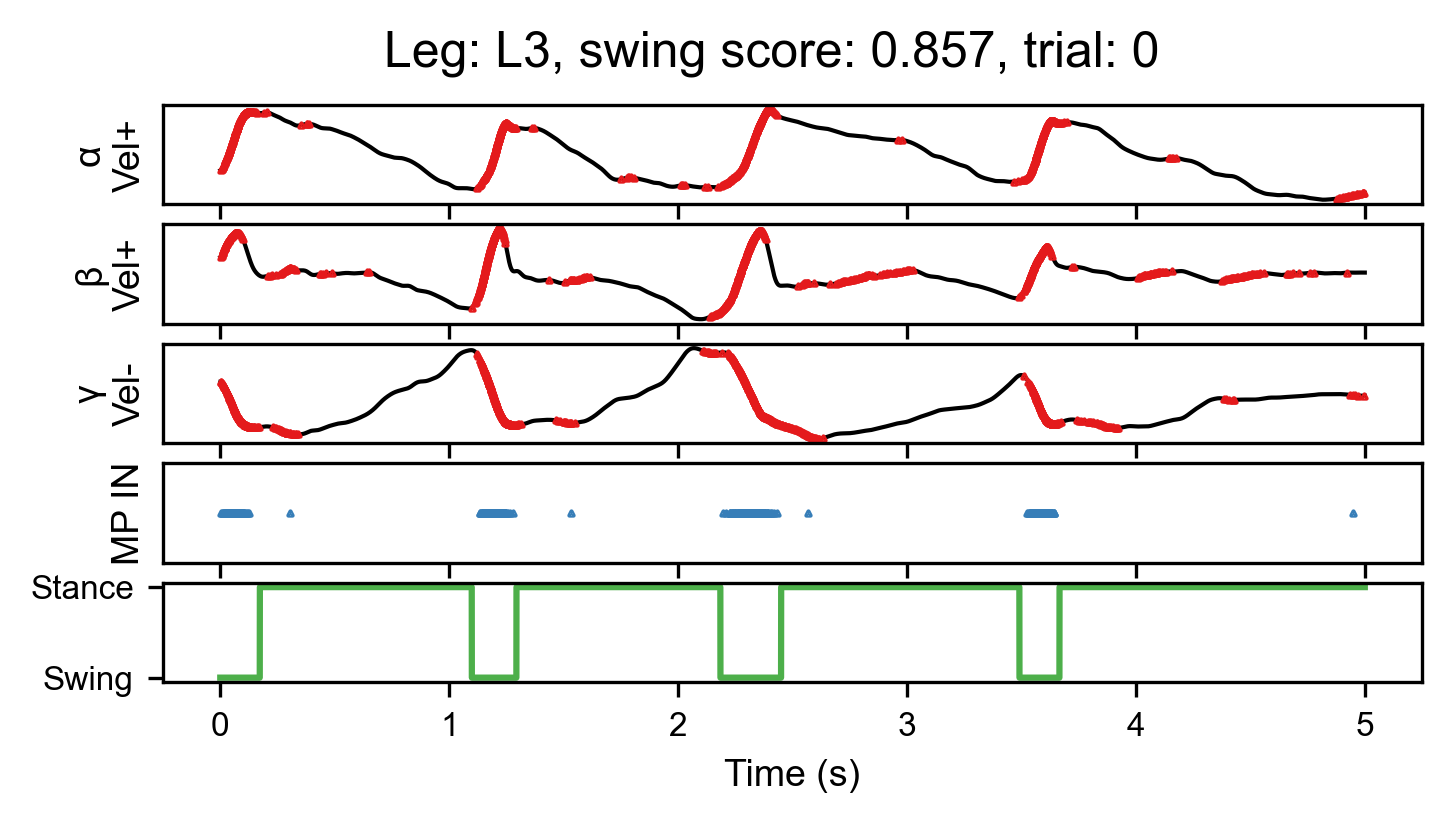

In [18]:
trial = 0
neuron_i = max_i[0]  # Index of the neuron with maximum swing score
max_leg = neuron_i // 112  # Determine the leg index of the neuron
max_leg_i = neuron_i % 112  # Index within the leg (ith movement primitive neuron)

# Plotting variables
joints = ['α', 'β', 'γ']
LEGS = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']

# Define a time array
time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

# Create subplots with shared x-axis
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, figsize=(5.7*0.95, 2.5), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]}, sharex='all')

axs = [ax1, ax2, ax3, ax4, ax5]

# Extract spike data and handle zeros as NaN for plotting
spike_primitive_plot = spike_primitive[:, neuron_i, trial].astype(float)
spike_primitive_plot[spike_primitive_plot == 0] = np.nan

spike_position_leg_i = spike_position[:, 6*max_leg:6*(max_leg+1), trial]
spike_velocity_leg_i = spike_velocity[:, 6*max_leg:6*(max_leg+1), trial]

# Plot joint angles and spikes for each joint
for i in range(3):
    axs[i].set_yticks([])
    axs[i].set_ylabel(f'{joints[i]}\n{perm[max_leg_i][i]}')

    spike_vel_pos = np.hstack((spike_velocity_leg_i[:, 2*i:2*(i+1)], spike_position_leg_i[:, 2*i:2*(i+1)])).astype(float)
    spike_vel_pos[spike_vel_pos == 0] = np.nan
    
    # Plot normalized joint angles and spikes
    axs[i].scatter(time, zscore.zscore(joint_angles[:, 3*max_leg + i, trial]) * spike_vel_pos[:, perm2[max_leg_i][i]-1], s=1, color=custom_colors[0], marker='^', zorder=2)
    axs[i].plot(time, zscore.zscore(joint_angles[:, 3*max_leg + i, trial]), color='black', linewidth=1, zorder=1)

# Plot spike activity of the movement primitive neuron
ax4.scatter(time, spike_primitive_plot, s=1, color=custom_colors[1], marker='^')

# Plot gait pattern
ax5.plot(time, gait[:, max_leg, trial], color=custom_colors[2])

ax4.set_yticks([])
ax4.set_ylabel('MP IN')

# Customize figure title and axis labels
fig.suptitle(f'Leg: {LEGS[max_leg]}, swing score: {scores[0][neuron_i]:.3f}, trial: {trial}')
ax5.set_yticks([0, 1])
labels = ['Swing', 'Stance']
ax5.set_yticklabels(labels)
ax5.set_xlabel('Time (s)')

# Save the figure
fig.savefig(f'images/motion_primitive_neuron/P2_fig3.png', bbox_inches='tight')


This cell plots the highest performing MP IN response for each target phase: 'swing', 'Swing→stance', 'stance', 'Stance→swing'. The likelihood of spiking for each bin is plotted.

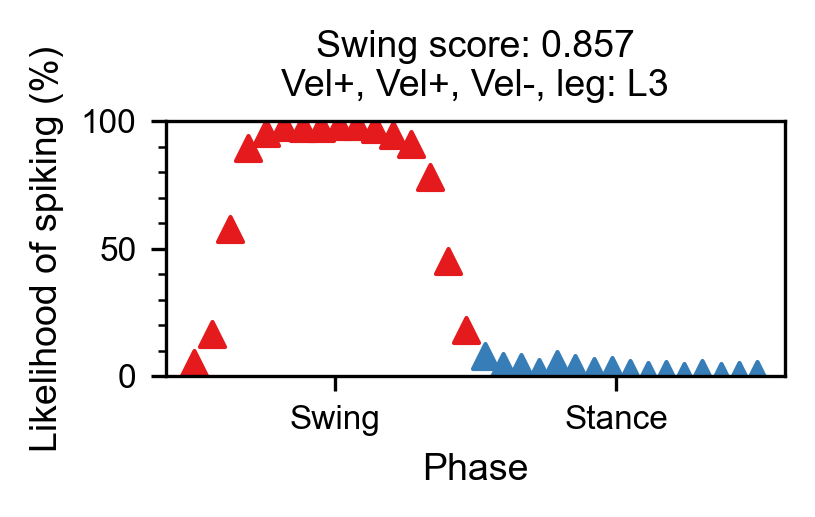

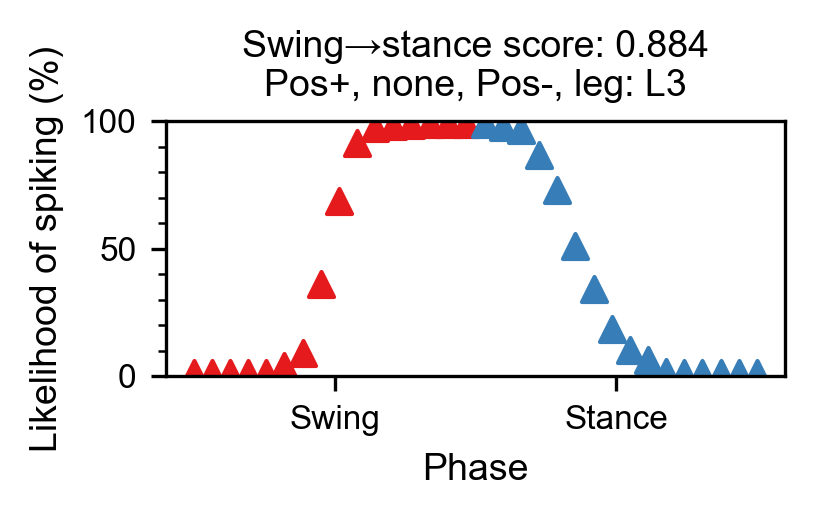

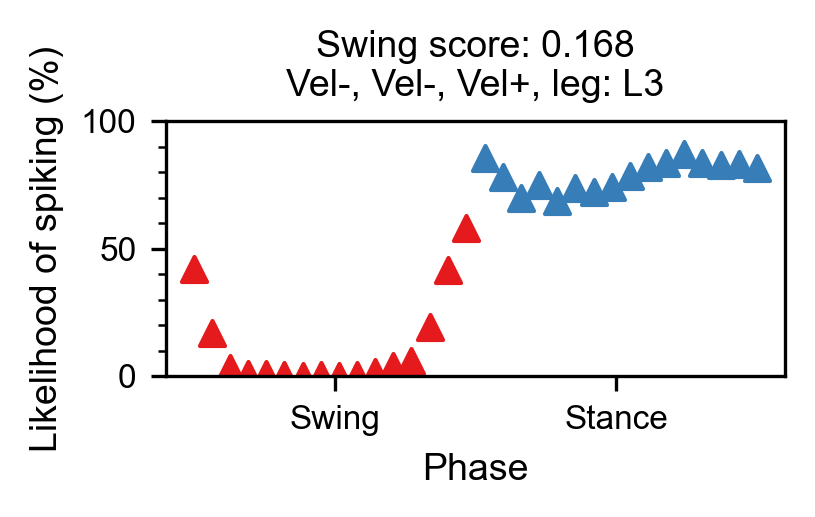

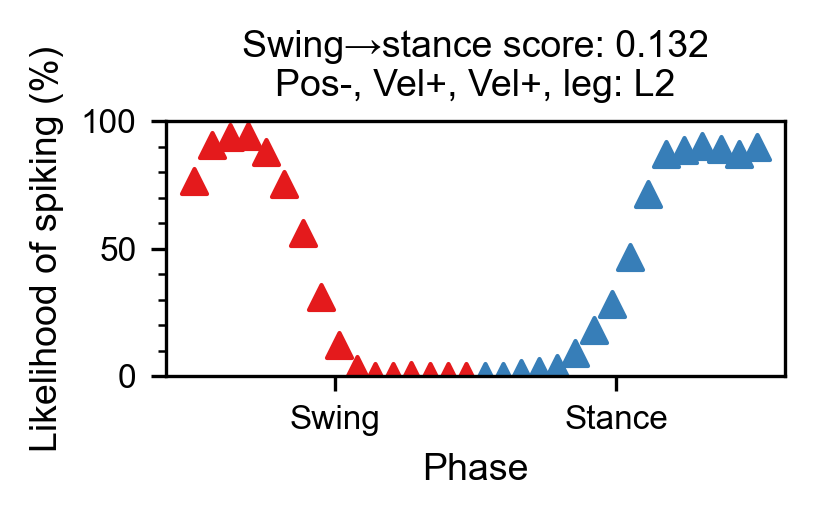

In [19]:
# Define naming conventions, phases and other plotting parameters
naming = ['P2_fig4a', 'P2_fig4b', 'P2_fig4c', 'P2_fig4d']
phase = ['swing', 'Swing→stance', 'stance', 'Stance→swing']
LEGS = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
x = [1, 0, 0.5, 0.5]

# Indices of the highest performing neurons for each phase (transition)
val_i = [max_i[0], max_i[1], min_i[0], min_i[1]]

# Iterate over each phase (transition) to create respective plots
for i in range(4):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(2.6, 2.6/1.618))
    
    # Plot the swing and stance likelihoods for the current phase
    if phase[i] in ['swing', 'stance']:
        ax.scatter(np.linspace(0, .725, num=N_BINS), swing_bin_likelihood[:, val_i[i]] * 100, color=custom_colors[0], marker='^')
        ax.scatter(np.linspace(.775, 1.5, num=N_BINS), stance_bin_likelihood[:, val_i[i]] * 100, color=custom_colors[1], marker='^')
        ax.set_title(f'Swing score: {scores[0][val_i[i]]:.3f}\n{perm[val_i[i] % 112][0]}, {perm[val_i[i] % 112][1]}, {perm[val_i[i] % 112][2]}, leg: {LEGS[val_i[i] // 112]}')
    else:
        ax.scatter(np.linspace(0, .725, num=N_BINS), swing_bin_likelihood[:, val_i[i]] * 100, color=custom_colors[0], marker='^')
        ax.scatter(np.linspace(.775, 1.5, num=N_BINS), stance_bin_likelihood[:, val_i[i]] * 100, color=custom_colors[1], marker='^')
        ax.set_title(f'Swing→stance score: {scores[1][val_i[i]]:.3f}\n{perm[val_i[i] % 112][0]}, {perm[val_i[i] % 112][1]}, {perm[val_i[i] % 112][2]}, leg: {LEGS[val_i[i] // 112]}')

    # Set labels and ticks for axes
    ax.set_ylabel('Likelihood of spiking (%)')
    ax.set_xlabel("Phase")
    ax.set_xticks([0.375, 1.125])
    ax.set_ylim([0, 100])
    
    # Set custom labels for x-axis
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[:] = ['Swing', 'Stance']
    ax.set_xticklabels(labels)
    
    # Configure minor ticks
    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    
    # Adjust layout and save the figure
    fig.tight_layout(pad=parameters['pad'])
    fig.savefig(f'images/motion_primitive_neuron/{naming[i]}.png', bbox_inches='tight')

This cell plots a distribution of scores for the two target vectors, grouped per leg.

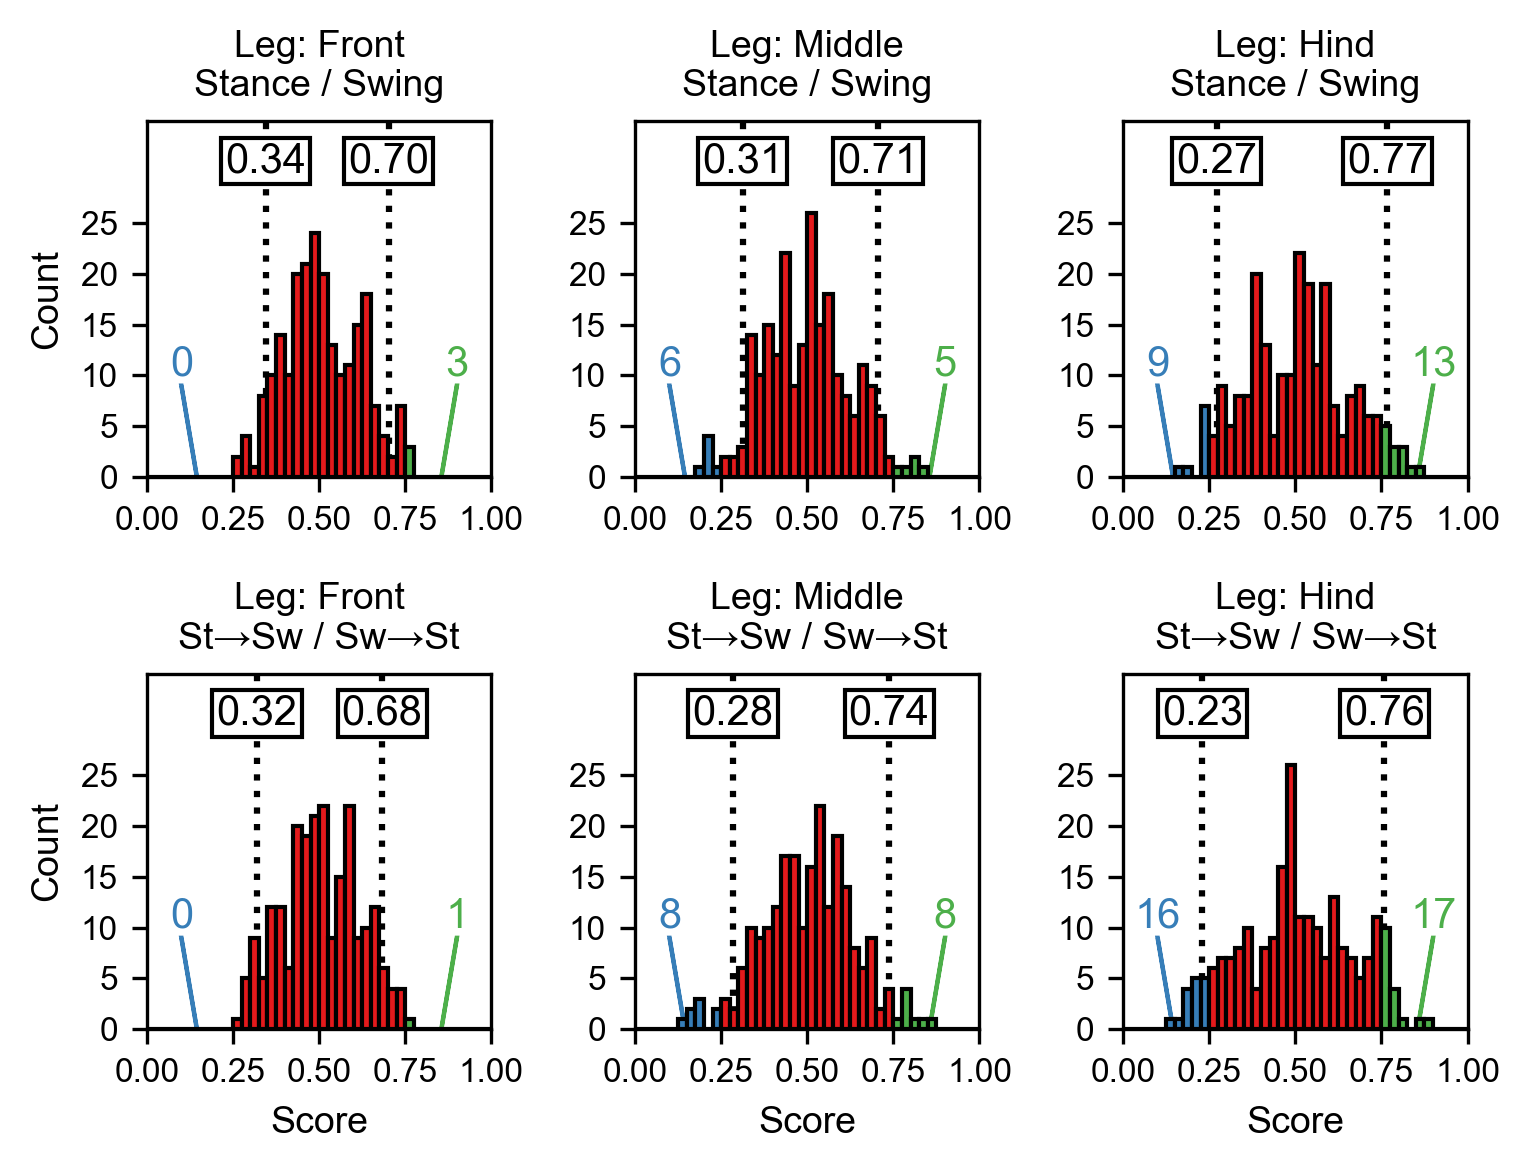

In [20]:
# Split up the scores pef leg for the two target vectors
scores_per_leg = [
    np.concatenate((scores[i][(j + 0) * N_PN_PER_LEG:(j + 1) * N_PN_PER_LEG], 
                    scores[i][(j + 3) * N_PN_PER_LEG:(j + 4) * N_PN_PER_LEG])) 
    for i in range(2) for j in range(3)
]

# Define naming
score_leg_names = [
    f'Leg: {j}\n{i}' 
    for i in ['Stance / Swing', 'St→Sw / Sw→St'] 
    for j in ['Front', 'Middle', 'Hind']
]

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(5.2, 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define histogram range and bins
bin_range = (0, 1)
bins = np.arange(0, 1.1, 0.025)  # Steps of 0.1

# Plot each array in a separate subplot
for i, arr in enumerate(scores_per_leg):
    # Plot histogram
    counts, edges, patches = axes[i].hist(arr, bins=bins, range=bin_range, edgecolor='black', color=custom_colors[0], zorder=100)
    
    # Set title and axis limits
    axes[i].set_title(score_leg_names[i])
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 35)  # Adjust based on expected counts
    axes[i].set_yticks([0, 5, 10, 15, 20, 25])
    axes[i].set_xticks([0, .25, .5, .75, 1])
    
    # Calculate and annotate MP IN below 25th and above 75th percentile
    count_25 = 0
    count_75 = 0
    for j, patch in enumerate(patches):
        if edges[j] < 0.250:
            patch.set_facecolor(color=custom_colors[1])
            count_25 += counts[j]
        elif edges[j] > 0.749:
            patch.set_facecolor(color=custom_colors[2])
            count_75 += counts[j]
        else:
            patch.set_facecolor(color=custom_colors[0])
    
    # Annotate MP INs and draw arrows
    axes[i].text(0.1, 10, f'{int(count_25)}', color=custom_colors[1], ha='center')
    axes[i].text(0.9, 10, f'{int(count_75)}', color=custom_colors[2], ha='center')
    axes[i].arrow(0.1, 9, 0.05, -10, color=custom_colors[1])
    axes[i].arrow(0.9, 9, -0.05, -10, color=custom_colors[2])
    
    # Plot vertical dashed lines at 5th and 95th percentiles (data driven high performers)
    percentile_95 = np.percentile(arr, 95)
    percentile_5 = np.percentile(arr, 5)
    axes[i].plot([percentile_5, percentile_5], [0, 35], color='black', linestyle='dotted')
    axes[i].plot([percentile_95, percentile_95], [0, 35], color='black', linestyle='dotted')
    
    # Annotate percentiles with values
    axes[i].text(percentile_5, 30, f'{percentile_5:.2f}', ha='center', 
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.1', linestyle='solid'))
    axes[i].text(percentile_95, 30, f'{percentile_95:.2f}', ha='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.1', linestyle='solid'))

# Set labels for x-axis of last row of subplots and y-axis of first column
for i in [3, 4, 5]:
    axes[i].set_xlabel('Score')

for i in [0, 3]:
    axes[i].set_ylabel('Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Save the figure with tight bounding box
fig.savefig(f'images/motion_primitive_neuron/P2_fig6.png', bbox_inches='tight')

The following plot was created to identify which first-order interneurons (INs) contributed most significantly to swing and stance encoding. To achieve this, the swing scores for all motion primitive (MP) interneurons (INs) were grouped according to velocity and position IN inputs for the three joints and six legs.

In [21]:
# Constants
N_LEGS = 6
N_JOINTS = 3
N_NEURON_TYPES = 5
N_PRIMITIVE_NEURONS_LEG = N_PRIMITIVE_NEURONS // N_LEGS

# Initialize the array with zeros
swing_scores_array = np.full((N_LEGS, N_JOINTS, N_NEURON_TYPES, 24), 0.0)

# Reshape the swing scores, (N_LEGS, N_PRIMITIVE_NEURONS_LEG)
swing_scores = scores[0].reshape(N_LEGS, -1)

# Populate the swing_scores_array
for i in range(N_LEGS):
    for j in range(N_PRIMITIVE_NEURONS_LEG):
        for k in range(N_JOINTS):
            first_zero_index = np.where(swing_scores_array[i, k, perm2[j][k], :] == 0)[0][0]
            swing_scores_array[i, k, perm2[j][k], first_zero_index] = swing_scores[i, j]

# Remove the third axis
swing_scores_array = np.delete(swing_scores_array, 0, axis=2)

# Calculate statistics: average, max, 25% and 75%
swings_average = np.median(swing_scores_array, axis=3)
swings_max = np.percentile(swing_scores_array, 90, axis=3) - swings_average
swings_min = swings_average - np.percentile(swing_scores_array, 10, axis=3)
swings_25 = np.percentile(swing_scores_array, 25, axis=3)
swings_75 = np.percentile(swing_scores_array, 75, axis=3)

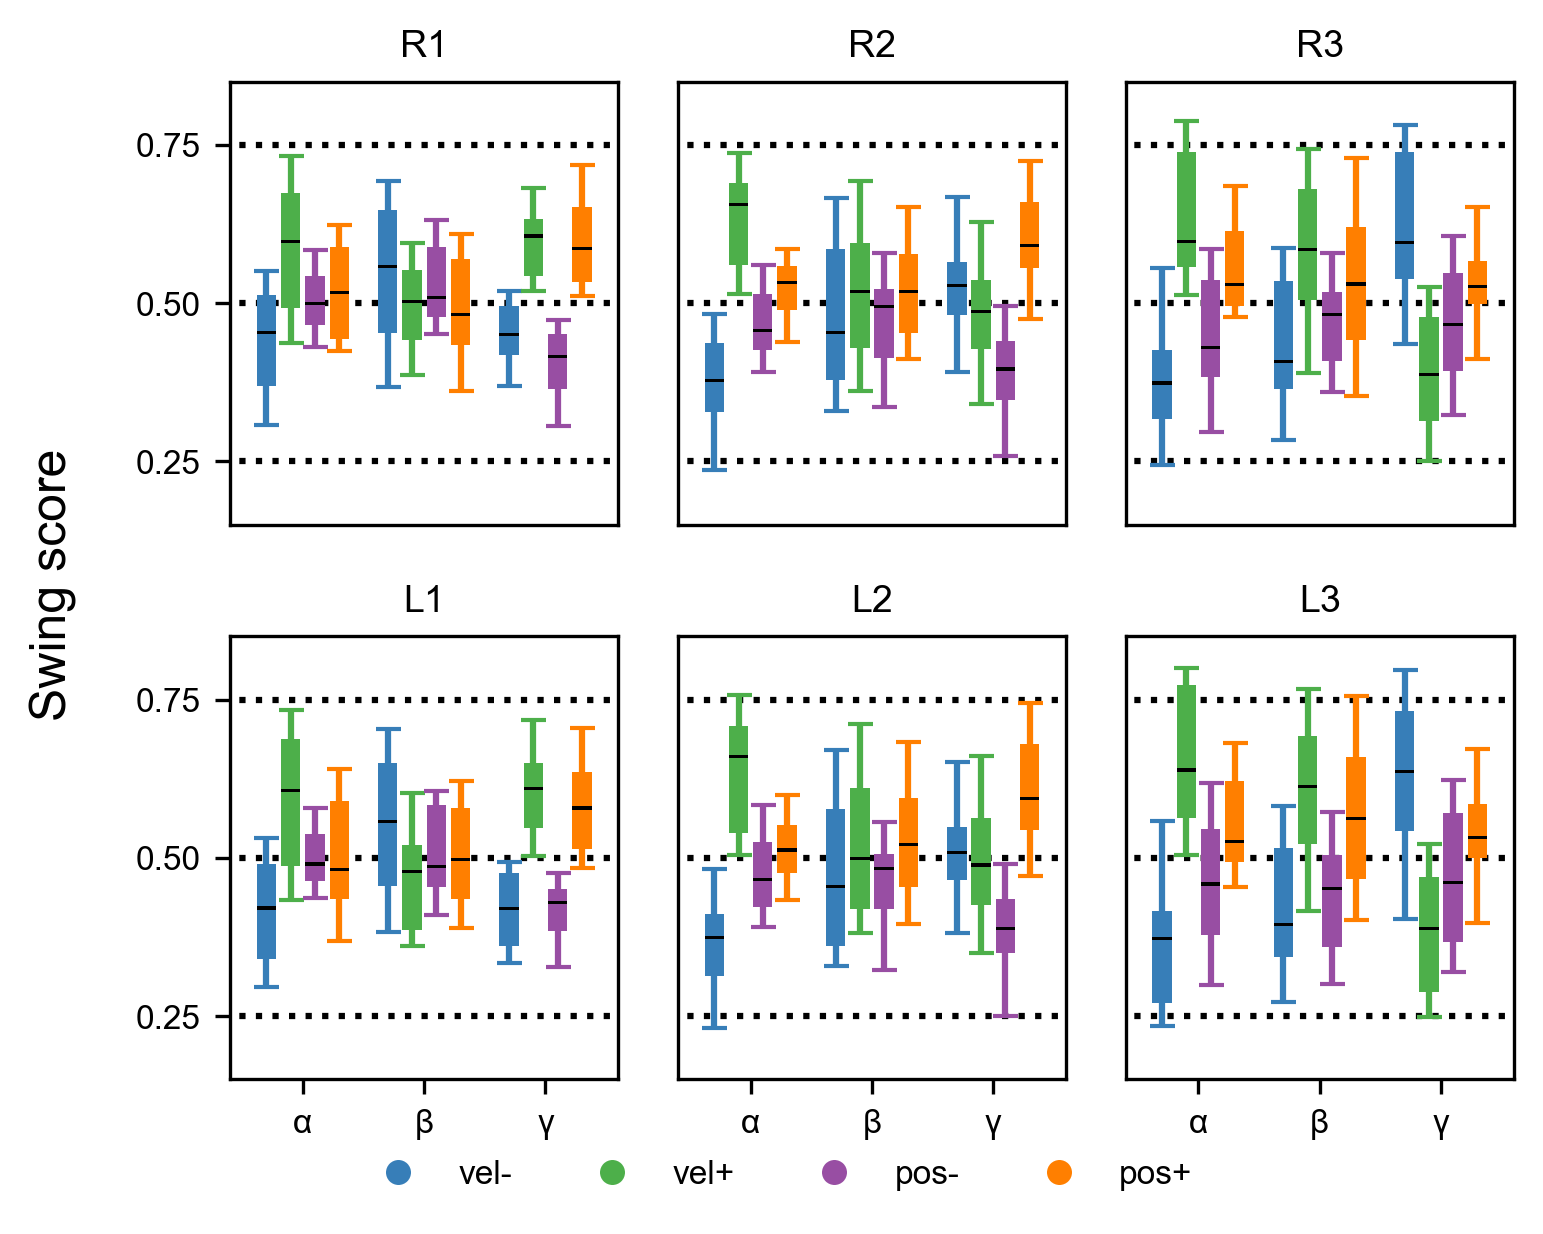

In [22]:
# Constants
x = [0, 1, 2, 3, 6, 7, 8, 9, 12, 13, 14, 15]
LEGS = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
Y_AXIS_LIMITS = [0.15, 0.85]
X_AXIS_LIMITS = [-0.3, 2.9]
Y_TICKS = [0.25, 0.5, 0.75]
X_TICKS = [0.3, 1.3, 2.3]
X_LABELS = ['α', 'β', 'γ']
LEGEND_LABELS = ['vel-', 'vel+', 'pos-', 'pos+']

# Create the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(5.2, 4))

# Loop through each subplot
for k in range(6):
    ax = axes[k // 3, k % 3]  # Select the subplot
    ax.set_ylim(Y_AXIS_LIMITS)  # Set y-axis limits
    ax.set_xlim(X_AXIS_LIMITS)  # Set x-axis limits

    # Add dotted lines at y = 0.25, 0.5, 0.75
    for y_val in Y_TICKS:
        ax.plot([-2, 5], [y_val, y_val], linestyle='dotted', color='black', zorder=0)

    # Loop through each condition (vel-, vel+, pos-, pos+)
    for j in range(4):
        # Plot error bars for the swing scores
        ax.errorbar(np.array([0, 1, 2]) + 0.2 * j, swings_average[k, :, j],
                    yerr=[swings_min[k, :, j], swings_max[k, :, j]], capsize=3, fmt='None', color=custom_colors[j + 1])

        # Add rectangles for the 25th to 75th percentile range
        for i in range(3):
            ax.add_patch(Rectangle((i + 0.2 * j - 0.08, swings_25[k, i, j]), 0.16,
                                   swings_75[k, i, j] - swings_25[k, i, j], facecolor=custom_colors[j + 1]))
            # Add a black line for the median value
            ax.add_patch(Rectangle((i + 0.2 * j - 0.08, swings_average[k, i, j] - 0.0025), 0.16, 0.005, facecolor='black',
                                   zorder=10))

    # Set y-ticks for the first column of subplots
    if k % 3 != 0:
        ax.set_yticks([])
    else:
        ax.set_yticks(Y_TICKS)

    # Set x-ticks and labels for the second row of subplots
    if k // 3 == 1:
        ax.set_xticks(X_TICKS)
        ax.set_xticklabels(X_LABELS)
    else:
        ax.set_xticks([])

    # Set the title for each subplot
    ax.set_title(LEGS[k])

# Add a y-axis label for the entire figure
fig.supylabel('Swing score')

# Create custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=LEGEND_LABELS[i], markerfacecolor=custom_colors[i + 1], markersize=7)
    for i in range(len(LEGEND_LABELS))
]
# Add legend to the figure
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=4, frameon=False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('images/motion_primitive_neuron/P2_fig5.png', bbox_inches='tight')

This cell tabulates the scores of a paired t-test between $vel_-$-$vel_+$ and $pos_-$-$pos_+$, respectively for each combination in the previous cell. High t-scores are expected for second-layer INs that fire more frequently during a specific phase compared to their negative counterpart.

In [23]:
# Define the angles and leg labels
angles = [r'$\alpha$', r'$\beta$', r'$\gamma$']
legs = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']

# Initialize arrays to store t-test results for position and velocity
t_test_pos = np.zeros_like(swing_scores_array[:, :, 0, 0])
t_test_vel = np.zeros_like(swing_scores_array[:, :, 0, 0])

# Perform paired t-tests for each leg and joint
for i in range(N_LEGS):
    for j in range(N_JOINTS):
        # t-test between vel+ and vel- scores
        t_test_vel[i, j] = stats.ttest_rel(swing_scores_array[i, j, 1, :], swing_scores_array[i, j, 0, :])[0]
        # t-test between pos+ and pos- scores
        t_test_pos[i, j] = stats.ttest_rel(swing_scores_array[i, j, 3, :], swing_scores_array[i, j, 2, :])[0]

# Create DataFrames to hold the t-test results and round them to 2 decimal places
df_vel = pd.DataFrame(data=np.around(t_test_vel.T, 2), index=angles, columns=legs)
df_pos = pd.DataFrame(data=np.around(t_test_pos.T, 2), index=angles, columns=legs)

# Save the t-test results to CSV files
df_vel.to_csv('results/primitive_t_test_vel.csv')
df_pos.to_csv('results/primitive_t_test_pos.csv')

# Print the DataFrames to display the results
print(df_vel)
print(df_pos)

             R1     R2     R3     L1     L2     L3
$\alpha$  11.75  14.47  10.27  11.51  14.57  10.70
$\beta$   -2.99   2.03   6.78  -4.14   2.37   7.34
$\gamma$  10.13  -4.86 -10.00  11.12  -0.79  -9.44
            R1     R2    R3    L1    L2    L3
$\alpha$  0.95   4.10  5.23  0.19  2.51  4.63
$\beta$  -3.36   7.07  4.47  0.29  6.86  7.00
$\gamma$  9.01  10.00  2.92  8.44  9.58  3.33
